### Preliminaries

In [1]:
# Autoreload all modules when changes are saved. 
%reload_ext autoreload
%autoreload 2  

# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit1

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
assert num_descriptors == opc_python.NUM_DESCRIPTORS
num_subjects = opc_python.NUM_SUBJECTS
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [6]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


### Create Molecular Matrix

In [9]:
X_training,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"training")
X_training.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 676 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (676x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (676x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (676x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (676x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors


(676, 3033)

In [10]:
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_other.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [11]:
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [12]:
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_other.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [13]:
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_int.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [14]:
X_all,good1,good2,means,stds,imputer = dream.make_X(molecular_data,["training","leaderboard"],good1=good1,good2=good2,means=means,stds=stds)
X_all.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (814x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (814x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (814x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (814x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors


(814, 3033)

In [15]:
Y_training,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [16]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [17]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Data preparation

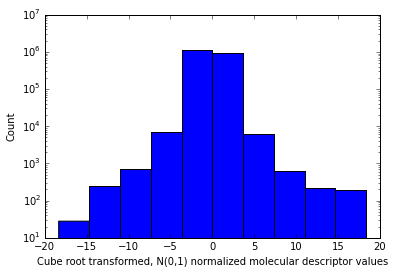

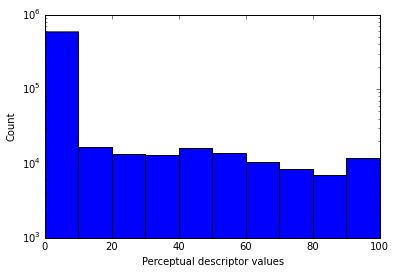

In [18]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(np.dstack([Y_training['subject'][subject] for subject in range(1,50)]).ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Perceptual descriptor values')

## Fitting and Generating Submission Files

In [19]:
write = True # Set to True to actually generate the prediction files.  
n_estimators = 1 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':None,
                'ple':100,
                'dec':500}
min_samples_leaf = {'int':1,
                'ple':1,
                'dec':1}
max_depth = {'int':None,
                'ple':10,
                'dec':10}
et = {'int':True,
      'ple':False,
      'dec':False,}

In [20]:
# Fit training data.  Ignoring warning that arises if too few trees are used.  
rfcs_leaderboard,score,rs = fit1.rfc_final(X_training,Y_training['subject'],
                            max_features,min_samples_leaf,max_depth,et,
                            n_estimators=n_estimators)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/ensemble/forest.py:659: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


For subchallenge 1:
	Score = 20.48
	int = 0.887
	ple = 0.006
	dec = 0.057


In [21]:
_ = loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,'leaderboard',1,Y_test=Y_leaderboard,write=write)
print(_['subject'][1]) # Print values for subject 1 to make sure it looks right.  

Score: 7.753835; rs = 0.366,0.014,0.012
Wrote to file with suffix "1438292055"
[[ 42.34285714  41.54686476   5.60843328 ...,   1.36483409   2.51090596
   36.7407241 ]
 [ 63.61428571  52.96721905   9.40142823 ...,   1.08847263   2.76405341
    9.3366509 ]
 [ 28.78571429  43.99913367   2.56798586 ...,   4.06749305   2.84697298
    6.32797077]
 ..., 
 [ 35.12857143  46.47263823   1.10357054 ...,   1.1367706    3.71459703
    4.86671283]
 [ 58.22857143  36.89306377   1.18494164 ...,   1.15328195   4.16433411
   33.5160842 ]
 [ 42.32857143  50.20143482   0.44057502 ...,   1.47910459   5.76158787
   10.20000581]]


/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:814: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)


In [22]:
rfcs,score,rs = fit1.rfc_final(X_all,Y_all_imp['subject'],
                            max_features,min_samples_leaf,max_depth,et,
                            n_estimators=n_estimators)

For subchallenge 1:
	Score = 20.76
	int = 0.886
	ple = 0.013
	dec = 0.059


In [23]:
_ = loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',1,write=False)
print(_['subject'][1]) # Print values for subject 1 to make sure it looks right. 

[[ 31.31428571  55.12729367   1.39366823 ...,   1.17580306   0.68461336
    9.72754892]
 [ 20.54285714  32.68542694   0.41039512 ...,   0.70340494   0.95115047
    5.70160495]
 [ 61.68571429  43.21221689   1.09082746 ...,   0.38090923   1.4155555
    8.54622266]
 ..., 
 [ 58.31428571  45.57401416   2.34636267 ...,   4.09689815   4.96473808
   10.40972326]
 [ 18.65714286  47.24555899   0.87964159 ...,   1.34618965   7.11336994
    8.85424796]
 [ 27.25714286  37.43448682   2.30880266 ...,   1.22476696   3.05726756
   35.48864745]]
